<a href="https://colab.research.google.com/github/johanhoffman/DD2363-VT19/blob/bozzato/Lab-5/bozzato_lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 5: Ordinary differential equations**
**Bozzato Federico**

# **Abstract**

In this lab, we will deepen how to approximate differential equations in order to solve complicate problem such as Newton's laws of motion, Einstein's general relativity and many others.

One typical procedure is to use time stepping methods, which we will see in details in this report.

The second part of the report consists of presenting the preys and predators model, which is frequently used to describe the dynamics of biological system where two populations interact.

#**About the code**

**Author:** Federico Bozzato

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2019 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [0]:
# Load neccessary modules.
from google.colab import files

import time
import numpy as np
from numpy import linalg
from matplotlib import pyplot as plt

## Useful functions from previous labs
In this report, I have needed functions implemented in the previous labs: these functions are **```newtonScalarNLeq```** and **```newtonNLsystems```** and their dependencies **```derivative```** and **```jacobian```**. Their implementations are explained [1].

**Observation:** I have modified some little parts in order to bettter suit their use for this lab.

In [0]:
def derivative(fun, h, opt):
  '''
  Calculates the first order derivative of the function @fun at the point @point.
  Parameters:
  - fun: function for which the 1st order derivative is wanted
  - point: point where to calculate the derivative
  Output:
  - derivative: central 1st order derivative
  '''
  ode= opt[0]
  step= opt[1]
  theta= opt[2]
  u0= opt[3]
  t0= opt[4]
  u1= opt[5]
  t1= opt[6]
  f1= fun(ode,step,theta,u0,t0,u1+h,t1)
  f2= fun(ode,step,theta,u0,t0,u1-h,t1)
  
  return (f1 - f2) / (2*h)               # central derivative f'= (f(x+1) - f(x-1))/2



def newtonScalarNLeq(fun, opt, h= 0.1, tol= 1e-5):
  '''
  Solve the scalar nonlinear equation f(x) = 0, where f(x) is the function @fun.
  The method used is Newton's method.
  Parameters:
  - fun: function 
  - point: starting guess for the iteration
  - der (default = None): derivative of the function @fun, calculated manually. 
  - h (default = 0.1): dx used in computing the derivative
  - tol (default= 1e-5): tolerance to stop the iterations
  Output:
  - x: point x such that f(x)=0
  - residuals: vector containing all the residuals for each iteration
  - iter: number of iterations for reaching the convergence
  '''
  
  ode= opt[0]
  step= opt[1]
  theta= opt[2]
  u0= opt[3]
  t0= opt[4]
  u1= opt[5]
  t1= opt[6]
  
  
  if not callable(fun):
    print('Error: impossible to continue! Parameter @fun is not callable()')
    return None, None
    
  # loop until convergence is not reached
  residuals= []
  x= u1.item()
  res= np.absolute(fun(ode,step,theta,u0,t0,x,t1))
  residuals.append(res)
  k= 1
  while res >= tol and k < 1000:
    alpha= derivative(fun, h, opt)
    
    x= x - fun(ode,step,theta,u0,t0,x,t1)/alpha
    res= np.absolute(fun(ode,step,theta,u0,t0,x,t1))
    residuals.append(res)
    k+= 1
    
  return x, np.array(residuals), k




def jacobian(fun,h,opt):
  '''
  Calculates the Jacobian matrix for the vector function @fun at the point @point.
  Parameters:
  - fun: function for which the Jacobian matrix is wanted
  - point: point where to calculate the Jacobian
  - h (default= 1): incrementation for the derivative
  Output:
  - jacobian: jacobian matrix of the function @fun
  '''
  
  odeSys= opt[0]
  step= opt[1]
  theta= opt[2]
  U0= opt[3]
  T0= opt[4]
  U1= opt[5]
  T1= opt[6]
    
  n= U0.shape[0]
  
  jacobian= np.zeros((n,n))
  for i in range(0,n):
    pp1= [p for p in U1]
    pp2= [p for p in U1]
    
    pp1[i]= pp1[i] + h
    pp2[i]= pp2[i] - h
    
    f1= fun(odeSys,step,theta,U0,T0,pp1,T1)
    f2= fun(odeSys,step,theta,U0,T0,pp2,T1)
    a= ((f1 - f2) / (2*h)).T
    jacobian[:,i]= ((f1 - f2) / (2*h)).T
  
  return jacobian
  
  
  
  
def newtonNLsystems(fun, opt, h=0.1, tol= 1e-5):
  '''
  Solve the vector nonlinear system of equations f(x) = 0, where f(x) is the
  vector function @fun.
  The method used is Newton's method.
  Parameters:
  - fun: vector function 
  - point: starting guess for the iteration
  - J (default= None): the Jacobian matrix of the vector function. It improves
    algorithm performances.
    - h (default = 0.1): dx used in computing the derivative
  - tol (default= 1e-5): tolerance to stop the iterations
  Output:
  - x: point x such that f(x)=0
  - residuals: vector containing all the residuals for each iteration
  - iter: number of iterations for reaching the convergence
  '''
  if not callable(fun):
    print('Error: impossible to continue! Parameter @fun is not callable()')
    return None, None

  
  odeSys= opt[0]
  step= opt[1]
  theta= opt[2]
  U0= opt[3]
  T0= opt[4]
  U1= opt[5]
  T1= opt[6]
  
  x= U0
  k = 1
  residuals= []
  res= linalg.norm(fun(odeSys,step,theta,U0,T0,x,T1))
  residuals.append(res)
  while res >= tol and k < 1000:                         # res= |f(x)|
    jac= jacobian(fun,h,opt)
    
    b= - fun(odeSys,step,theta,U0,T0,x,T1)
    dx, _, _, _ = linalg.lstsq(jac, b, rcond=None)       # built-in function
    x = x + dx                    
    res= linalg.norm(fun(odeSys,step,theta,U0,T0,x,T1))
    residuals.append(res)
    k+= 1
    
  return x, np.array(residuals), k

# **Introduction**

A differential equation is a mathematical equation that relates some function with its derivatives. In applications, the function usually represent physical quantities, the derivatives represent their rates of change, and the equation defines the relationship between the two [2].

There exist many type of differential equations, but we will focus only on ODEs, that are *ordinary differential equations*.

Contrary to the previous labs, this lab is divided into two part: the Mandatory assignment, where the methods are presented and tested with mathematical problems, and the Extra assignment, where it is shown how to use ODEs in a very common model, that is *prey-predator model*.



#Mandatory assignment

##Methods

###1. Time stepping for scalar initial value problem $du/dt= f(u,t)$

Given the ordinary differential equation 

>$
\dot{u}(t)=f(u(t),t)
$

where $u: [0,T]\to\mathbb{R}$ and $f:\mathbb{R}\times\mathbb{R}^+\to\mathbb{R}$, we refer to this problem with the name of *scalar initial value problem* [2].

####Implementation
There exists many methods for solving the scalar initial value problem, but we will study only the time stepping methods, which consist of using numerical methods over the discretized interval of time $[0,T]$.

The implementation presented in the below cells is called $\theta$-method, where depending on the parameter $\theta$ it is possible to use three different time stepping method:
* if $\theta = 1$ we obtain the explicit Euler method
* if $\theta = 0$ we obtain the implicit Euler method
* if $\theta = 0.5$ we obtain the trapezoidal rule

Below there is the pseudocode taken from [4]:


```
U(0) = u0
for n = 1, 2, ..., N do:
  U(n) = U(n-1) + k_n * ((1-theta)*f(U(n),t(n)) + theta*f(U(n-1),t(n-1)))
end
```

where ```k_n``` is the time step at the $n$-th iteration. 

As we can see, for both the implicit Euler method and the trapezoidal method we need to solve the algebrac equation

>$
x= U_{n-1} + k_n\left( \left(\left(1-\theta\right)f(x,t_n)  + \theta f(U_{n-1},t_{n-1})\right)\right)
$

while for the explicit Euler method, each iteration depends only on the last iteration. 

In order to solve the last equation, we can rewrite it as

>$
 g(x)= 0
$

where 

>$
 g(x)= U_{n-1} + k_n\left( \left(\left(1-\theta\right)f(x,t_n)  + \theta f(U_{n-1},t_{n-1})\right)\right)- x
$

It is possible to solve the equation with many methods, but the one that has been used is the Newton's method for nonlinear equations [1,5].

In [0]:
def odeSolver(T, odeFun, theta, u0, N):
  '''
  Solves the ordinary differential equation @odeFun given in input, for t in 
  range(0,T+step), where step is the ratio between the number of intervals N and 
  the final time T.
  Parameters:
  - T: final time T
  - odeFun: ODE to be solved
  - theta: parameter used for choosing the method to solve the ODE. (theta = 0 
    is implicit Euler, theta = 1 is explicit Euler, theta = 0.5 trapezoidal rule)
  - u0: initial value (initial conditions for the ODE)
  - N: number of subintervals dividing the interval [0,T]
  Output:
  - t: discrited vector of time
  - U: function u solving the ODE @odeFun
  '''
  
  def stepFunction(ode,step,theta,u0,t0,u1,t1):
    '''
    Defines the function
    
        g(x) = U[n-1] + k_n * ((1-theta) * f(U[n],t[n]) + theta * f(U[n-1],t[n-1])) - x
    
    explained in the above cell. 
    
    '''
    g= u0 + step*((1-theta) * ode(u1,t1) + theta * odeFun(u0,t0)) - u1
   
    return g
  
  step= T/N
  t= np.arange(0, T+step, step)
  
  U= np.zeros((len(t),1))
  U[0]= u0
  
  for i in range(1,len(t)): 
    opt= [0 for _ in range(0,7)]
    opt[0]= odeFun
    opt[1]= step
    opt[2]= theta
    opt[3]= U[i-1][0]
    opt[4]= t[i-1]
    opt[5]= U[i-1][0]
    opt[6]= t[i]
    if theta != 1:
      U[i]= newtonScalarNLeq(stepFunction, opt, h= 0.1, tol= 1e-5)[0]
    else:
      U[i]= U[i-1] + step * odeFun(U[i-1],t[i-1]) 
  
  return t, U

###2. Time stepping for system of initial value problem $du/dt = f(u,t)$

In the previous paragraph, we have explained how to solve one ordinary differential equation with the time stepping method, but is it possible to use the same methods also for systems of ODEs? The answer is obviously affermative and the code for solving systems of ODEs is very similar to the one we explained in the previous paragraph.

As we can see from the below cell, the only difference is to handle vectors and matrices instead of scalars.

In [0]:
def systemOdeSolver(T, odeSystem, theta, u0, N):
  '''
  Solves the system of ODEs @odeSystem given in input, for t in range(0,T+step), 
  where step is the ratio between the number of intervals N and the final time T.
  Parameters:
  - T: final time T
  - odeSystem: system of ODEs to be solved
  - theta: parameter used for choosing the method to solve the ODE. (theta = 0 
    is implicit Euler, theta = 1 is explicit Euler, theta = 0.5 trapezoidal rule)
  - u0: initial value (initial conditions for the ODE)
  - N: number of subintervals dividing the interval [0,T]
  Output:
  - t: discritized vector of time
  - U: vector of functions u solving the system @odeSystem
  '''

  def stepFunction(odeSys,step,theta,u0,t0,u1,t1):
    s= (step*((1-theta) * odeSys(u1,t1) + theta * odeSys(u0,t0))).flatten()
    g= u0 + s - u1
    
    return g
  
  
  if not isinstance(u0,np.ndarray):
    u0= np.array(u0)
  
  
  step= T/N
  t= np.arange(0, T+step, step)
  U= np.zeros((u0.shape[0],t.shape[0]))
  U[:,0]= u0
  
  for i in range(1,len(t)):
    opt= [0 for _ in range(0,7)]
    opt[0]= odeSystem
    opt[1]= step
    opt[2]= theta
    opt[3]= U[:,i-1]
    opt[4]= t[i-1]
    opt[5]= U[:,i-1]
    opt[6]= t[i]
    if theta != 1:
      U[:,i]= newtonNLsystems(stepFunction, opt, h= 0.1, tol= 1e-5)[0]
    else:
      U[:,i]= U[:,i-1] + step * odeSystem(U[:,i-1],t[i-1]).flatten()
    
  return t, U
 

##Results
Results of the tests done on the two above functions are shown in the following cells, where we can compare the use of the three different methods (implicit and explicit Euler method and trapezoidal rule). 

Moreover I have compared each method in term of MSE (mean squared error) in based on the number of subintervals taken for the discritization of the time domain. Almost all the trials are done within a time range of $[0,10]$ and with a number of subintervals in the range $[1,40]$.


In [0]:
def analysis1D(anFun, apprFun, u0, T, Nmax, nTrials):
  
  theta = [1, 0, 0.5]
  
  times= []
  for th in theta:
    MSE= []
    tm= []
    for i in range(0,nTrials):
      N= Nmax/nTrials*(i+1)
      t0= time.time()
      x, y= odeSolver(T,apprFun,th,u0,N)
      t1= time.time()
      
      tm.append(t1-t0)
      y=y.flatten()
      y_true= np.array(anFun(x))
      res= np.abs(y - y_true)**2
      mse= sum(res)/y.shape[0]

      MSE.append([N, np.log10(mse)])  
     
    times.append(tm)
    MSE= np.array(MSE)
    
    print('              --------- THETA = {} ----------'.format(th))
    plt.figure()
    plt.plot(x,y,'--')
    plt.plot(x,y_true)
    plt.title('Approximated solution vs analitical solution')
    plt.xlabel('time')
    plt.ylabel('u(t)')
    plt.show()
    
    plt.figure()
    plt.plot(MSE[:,0],MSE[:,1],'-o')
    plt.title('MSE')
    plt.xlabel('number of intervals')
    plt.ylabel('log10( MSE )')
    plt.show()
    
  
  times= np.array(times).T
    
  plt.figure()
  plt.plot(MSE[:,0],np.log10(times))
  plt.xlabel('number of intervals')
  plt.ylabel('log10( time )')
  plt.title('Execution time comparison')
  plt.legend(['explicit Euler', 'implicit Euler', 'trapezoidal rule'])
  plt.show()
  
  


def analysisND(anFun, apprFun, u0, T, Nmax, nTrials):
  
  theta = [1, 0, 0.5]
  times= []
  
  for th in theta:
    MSE= []
    x_res= []
    tm= []
    for i in range(0,nTrials):
      N= Nmax/nTrials*(i+1)
      x_res.append(N)
      
      t0= time.time()
      x, y= systemOdeSolver(T,apprFun,th,u0,N)
      t1= time.time()
      tm.append(t1-t0)
      
      y_true= np.array(anFun(x))
      res= np.abs(y - y_true)**2
      mse= (np.sum(res,axis=1)/y.shape[0]).T
      MSE.append(np.log10(mse))
    
    times.append(tm)
    MSE= np.array(MSE)
    
    print('              --------- THETA = {} ----------'.format(th))
    plt.figure()
    plt.plot(x,y.T,'--')
    plt.plot(x,y_true.T)
    plt.title('Approximated solution vs analitical solution')
    st= []
    for k in range(1,len(u0)+1):
      st.append('approximated x{}'.format(k))
    for k in range(1,len(u0)+1):
      st.append('analytical x{}'.format(k))
      
    plt.xlabel('time')
    plt.ylabel('u(t)')
    plt.legend(st)
    plt.show()
    
    plt.figure()
    plt.plot(x_res,MSE,'-o')
    plt.title('MSE with theta={}'.format(th))
    plt.xlabel('number of intervals')
    plt.ylabel('log10(MSE)')
    plt.legend(['x{}'.format(k) for k in range(1,len(u0)+1)])
    plt.show()
    
  times= np.array(times).T
  
  plt.figure()
  plt.plot(x_res,np.log10(times))
  plt.xlabel('number of intervals')
  plt.ylabel('log10( time )')
  plt.title('Execution time comparison')
  plt.legend(['explicit Euler', 'implicit Euler', 'trapezoidal rule'])
  plt.show()

###1. Time stepping for scalar initial value problem $du/dt = f(u,t)$

In order to test the function **```odeSolver```**, I have used the following equations:

1. $\dot{u}(t)=-u(t)\cos{t}$ with $u(0)=1$. The solution is $u(t)=e^{-\sin{t}}$.
2. $\dot{u}(t)=\dfrac{1}{u(t)(t+1)}$ with $u(0)=1$. The solution is $u(t)=\sqrt{2\log{(t+1)}+1}$
3. $\dot{u}(t)=-u^2$ with $u(0)=5$. The solution is $u(t)=\dfrac{5}{5t+1}$

-----------------------------------------------------------------------
------------------------- ODE n° 1 ------------------------------------
-----------------------------------------------------------------------
              --------- THETA = 1 ----------


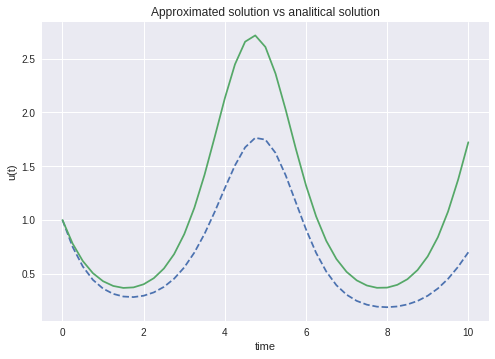

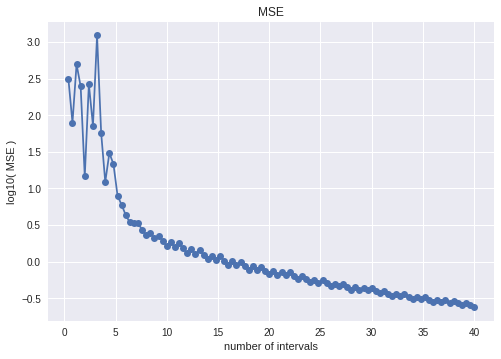

              --------- THETA = 0 ----------


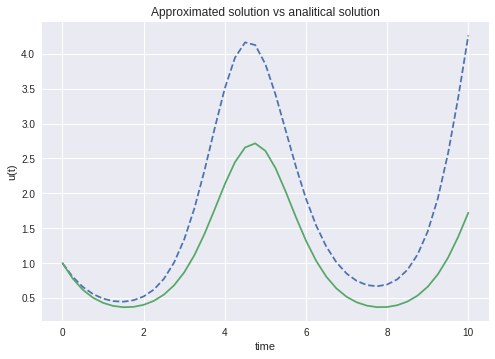

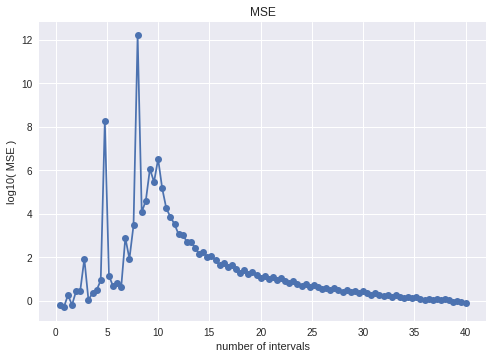

              --------- THETA = 0.5 ----------


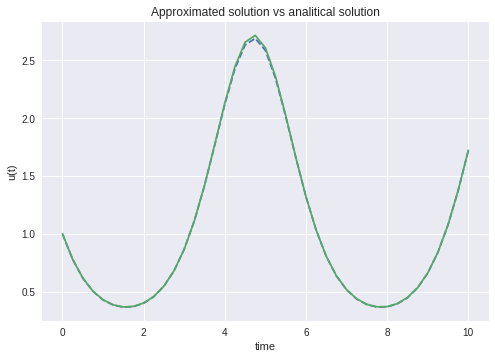

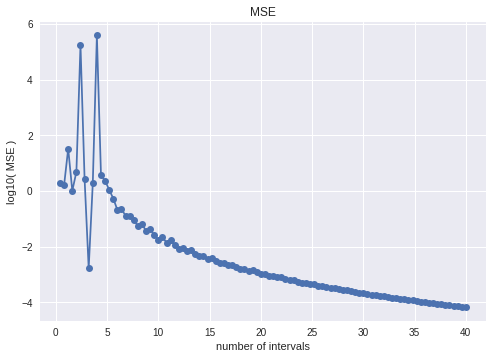

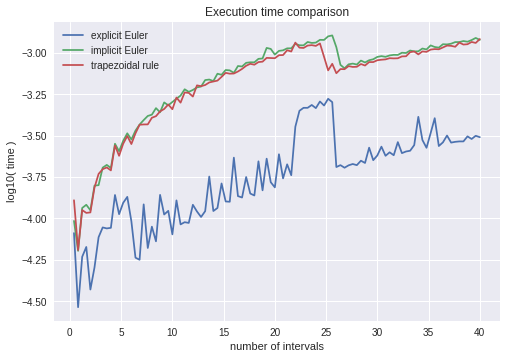

-----------------------------------------------------------------------
------------------------- ODE n° 2 ------------------------------------
-----------------------------------------------------------------------
              --------- THETA = 1 ----------


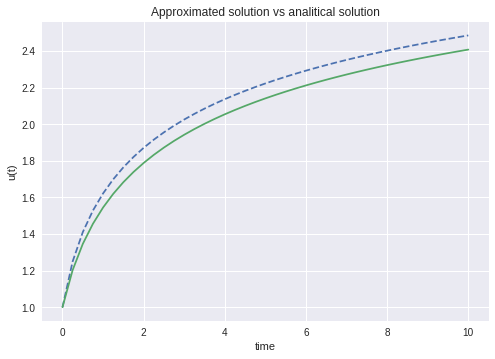

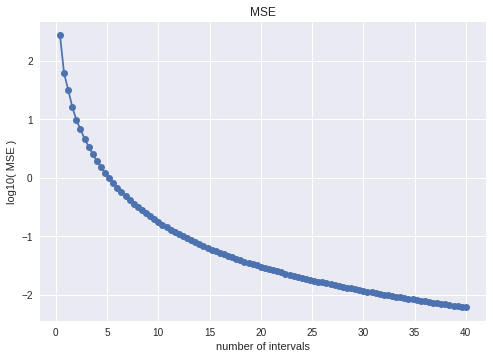

              --------- THETA = 0 ----------


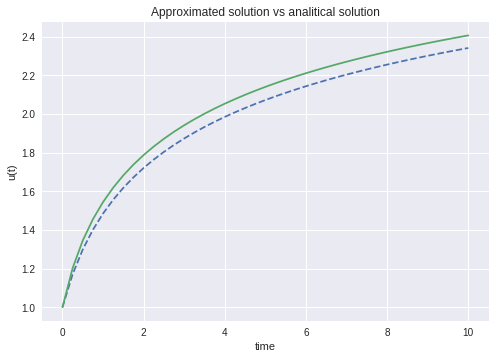

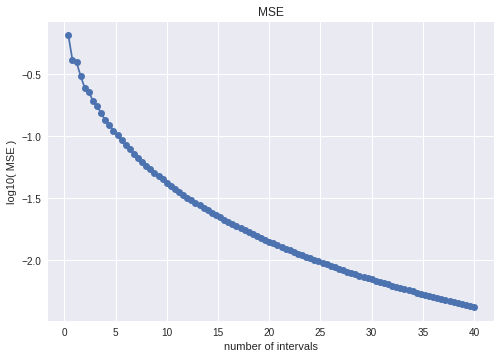

              --------- THETA = 0.5 ----------


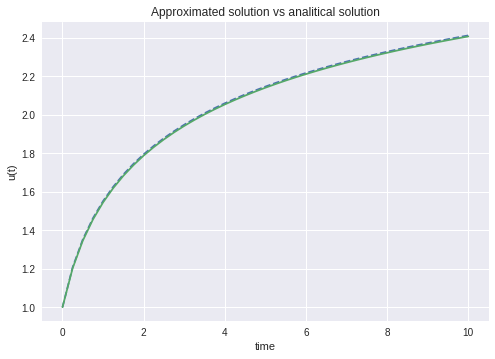

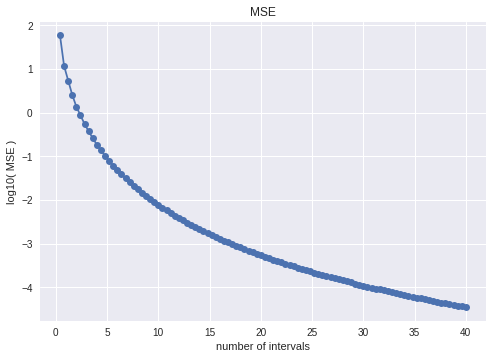

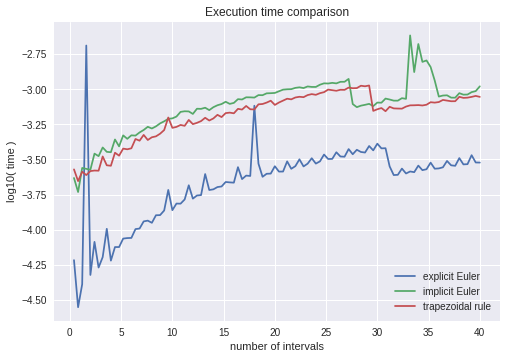

-----------------------------------------------------------------------
------------------------- ODE n° 3 ------------------------------------
-----------------------------------------------------------------------
              --------- THETA = 1 ----------


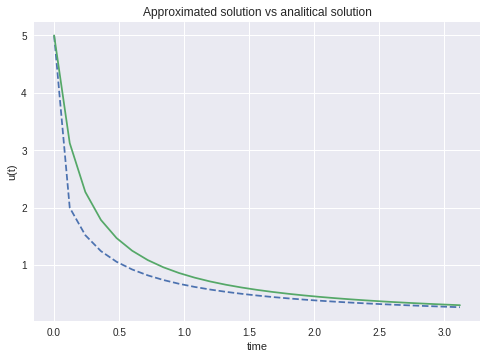

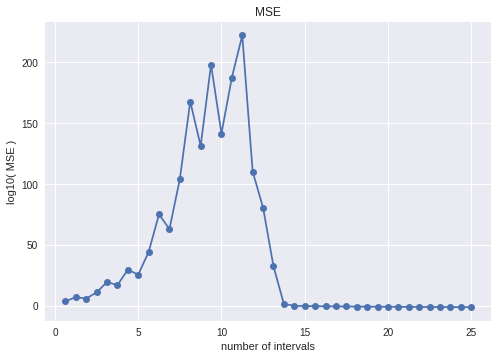

              --------- THETA = 0 ----------


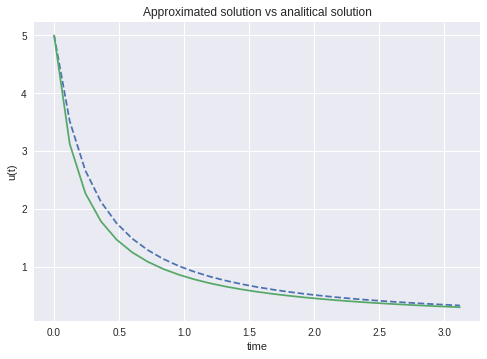

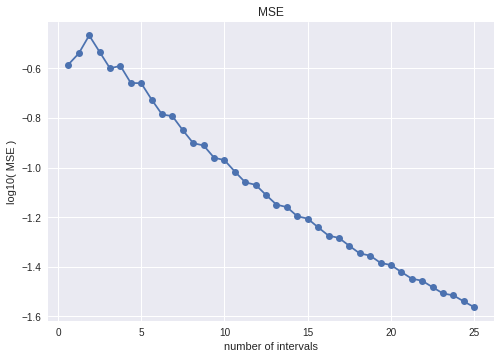

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in double_scalars


              --------- THETA = 0.5 ----------


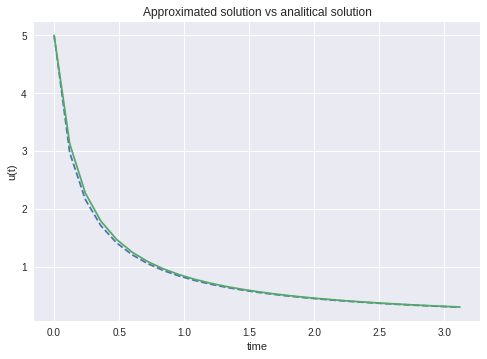

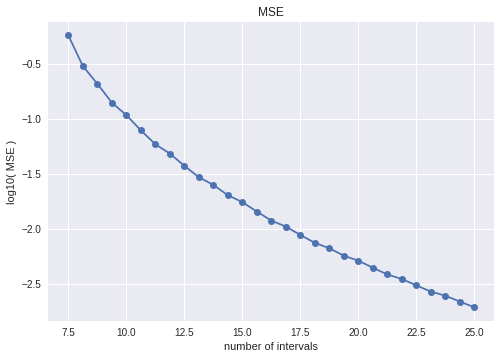

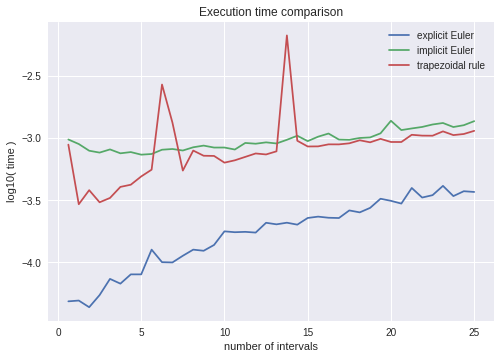

In [7]:
print('-----------------------------------------------------------------------')
print('------------------------- ODE n° 1 ------------------------------------')
print('-----------------------------------------------------------------------')

def fun(t):
  return np.e**(-np.sin(t))

def odeFun(u,t):
  return -u*np.cos(t)
    

u0= 1
T= 10
Nmax= 40
nTrials= 100

analysis1D(fun, odeFun, u0, T, Nmax, nTrials)


print('-----------------------------------------------------------------------')
print('------------------------- ODE n° 2 ------------------------------------')
print('-----------------------------------------------------------------------')


def odeFun(u,t):
  return 1/(u*(t+1))

def fun(t):
  return np.sqrt(2*np.log(t+1)+1)

u0= 1
T= 10
Nmax= 40
nTrials= 100

analysis1D(fun, odeFun, u0, T, Nmax, nTrials)

print('-----------------------------------------------------------------------')
print('------------------------- ODE n° 3 ------------------------------------')
print('-----------------------------------------------------------------------')

def odeFun(u,t):
  return -u**2

def fun(t):
  return 5/(5*t+1)

u0= 5
T= 3
Nmax= 25
nTrials= 40

analysis1D(fun, odeFun, u0, T, Nmax, nTrials)



###2. Time stepping for system of initial value problems $du/dt = f(u,t)

In order to test the function **```systemOdeSolver```**, I have used the following systems:

1. $\begin{cases}
\dot{x}_1 = 3x_1 + t \\
\dot{x}_2 = x_2 +1 \\
\dot{x}_3 = x_2 + x_3
\end{cases}
$ with $\vec{x}(0)=\begin{pmatrix}
0 & 0 & 0\end{pmatrix}^T$. The solution is $\begin{cases}
  x_1= \dfrac{1}{9} e^{3t} - \dfrac{1}{3}t - \dfrac{1}{9} \\
  x_2= e^t -1 \\
  x_3= (t-1)e^t +1
\end{cases}$

2. $\begin{cases}
\dot{x}_1= 6x_1 + 5x_2 + e^{2t} \\
\dot{x}_2= x_1 + 2x_2 +2e^{2t}
\end{cases}$ with $\vec{x}(0)= \begin{pmatrix}
0 & 0 
\end{pmatrix}^T$. The solution is $\begin{cases}
  x_1= \dfrac{1}{3}e^{t}(5e^{6t}+1) - \dfrac{7}{6}e^t(e^{6t}-1)-2e^t \\
  x_2= \dfrac{1}{3}e^{t}(e^{6t}-1) - \dfrac{7}{30}e^t(e^{6t}+5)+\dfrac{7}{5}e^{2t} 
\end{cases}$

3. $\begin{cases}
\dot{x}_1= 4x_1 + 7x_2\\
\dot{x}_2= -2x_1 - 5x_2
\end{cases}$ with $\vec{x}(0)=\begin{pmatrix}
 2 & 1
\end{pmatrix}^T$. The solution is $\begin{cases}
  x_1(t)= \dfrac{2}{5}e^{-3t}(7e^{5t}-2) + \dfrac{7}{5}e^{-3t}(e^{5t}-1) \\
  x_2(t)= -\dfrac{4}{5}e^{-3t}(e^{5t}-1) - \dfrac{1}{5}e^{-3t}(2e^{5t}-7)
\end{cases}$

-----------------------------------------------------------------------
------------------------ SYSTEM n° 1 ----------------------------------
-----------------------------------------------------------------------
              --------- THETA = 1 ----------


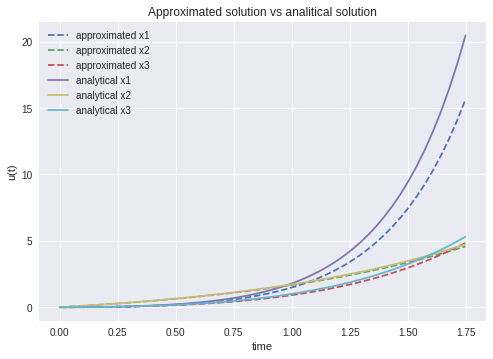

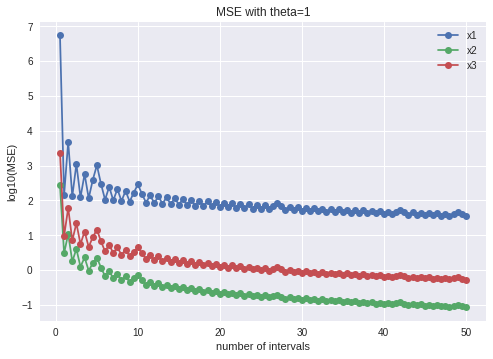

              --------- THETA = 0 ----------


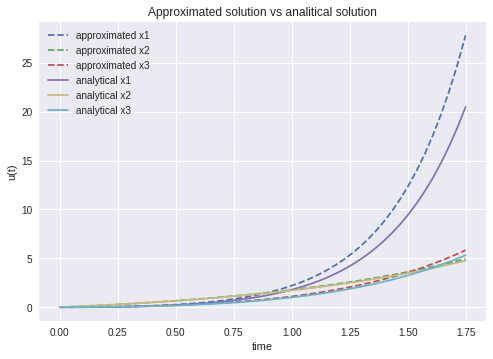

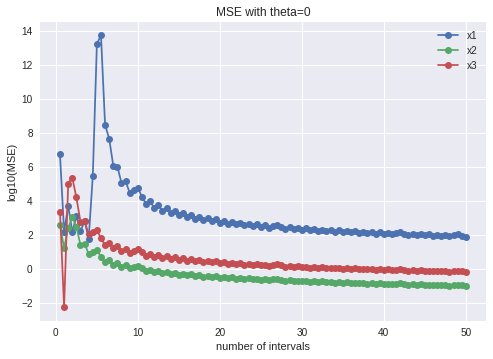

              --------- THETA = 0.5 ----------


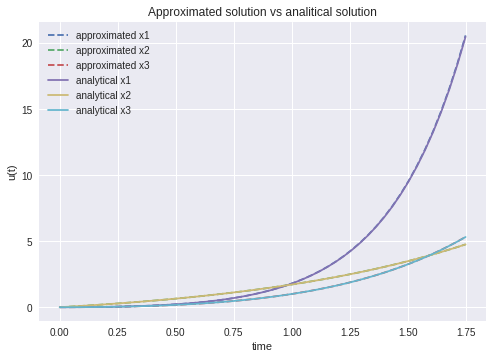

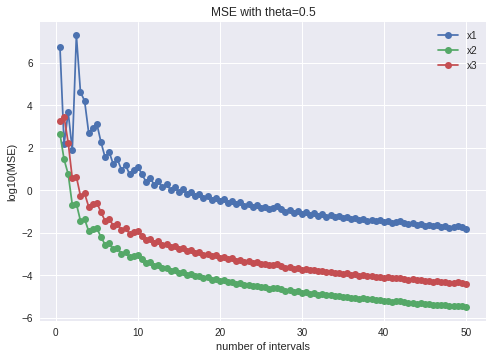

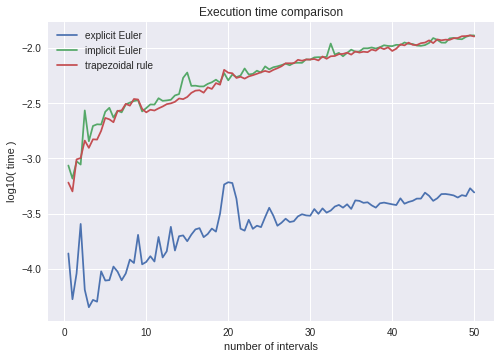

-----------------------------------------------------------------------
------------------------ SYSTEM n° 2 ----------------------------------
-----------------------------------------------------------------------
              --------- THETA = 1 ----------


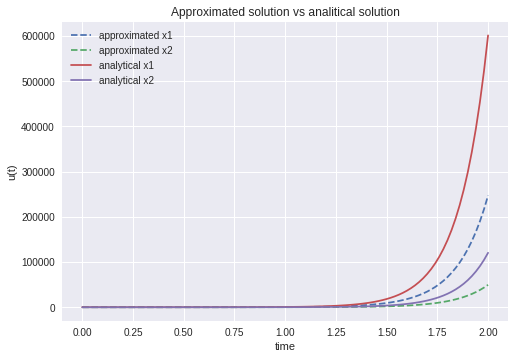

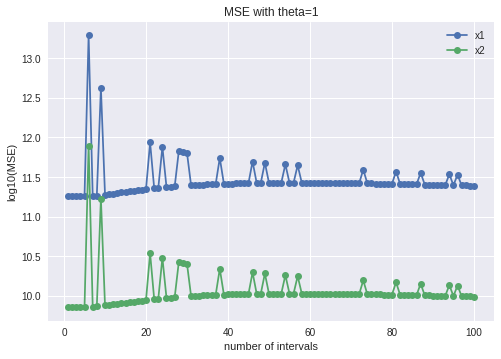

              --------- THETA = 0 ----------


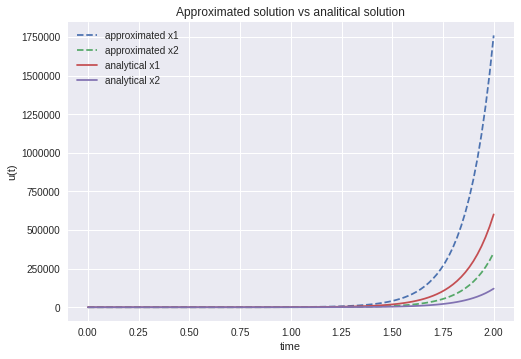

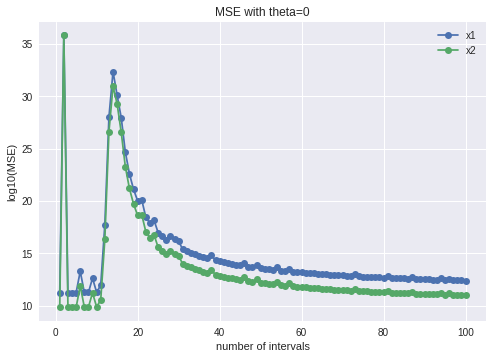

              --------- THETA = 0.5 ----------


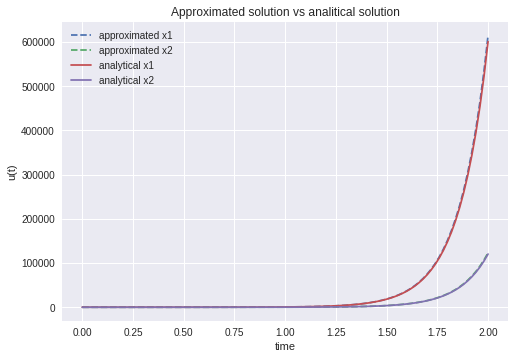

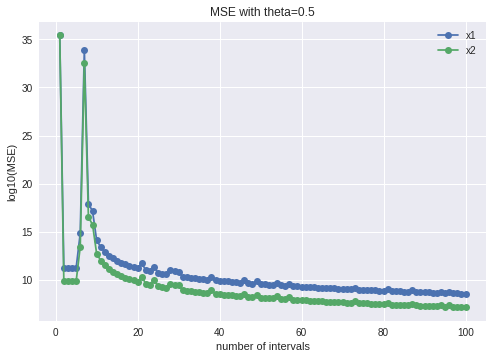

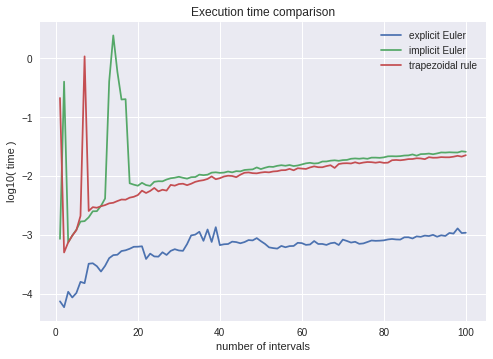

-----------------------------------------------------------------------
------------------------ SYSTEM n° 3 ----------------------------------
-----------------------------------------------------------------------
              --------- THETA = 1 ----------


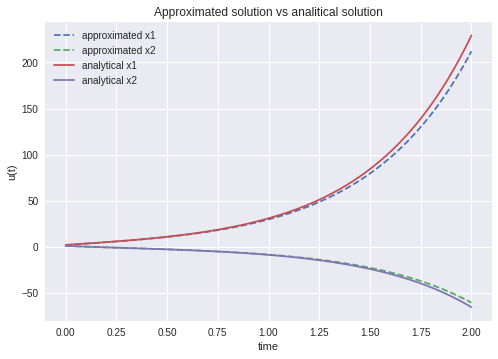

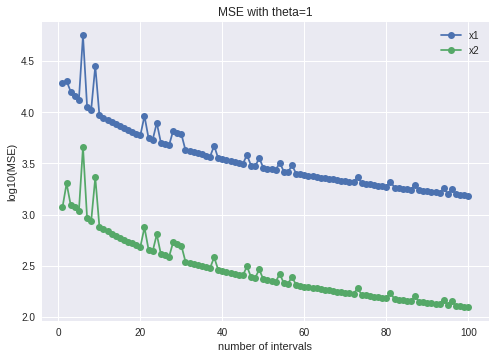

              --------- THETA = 0 ----------


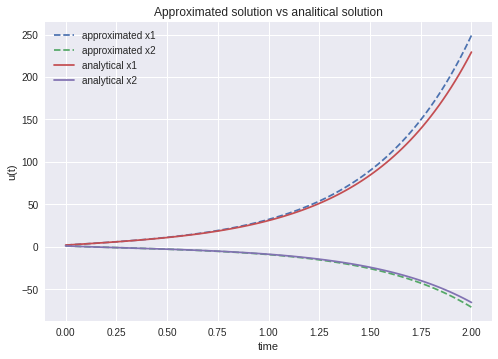

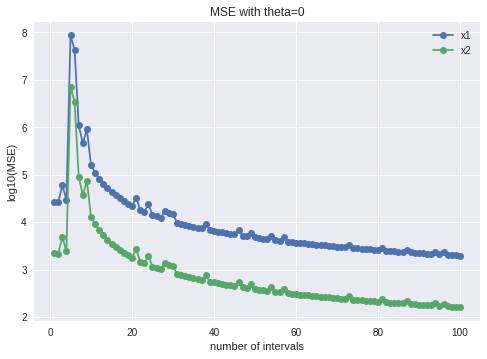

              --------- THETA = 0.5 ----------


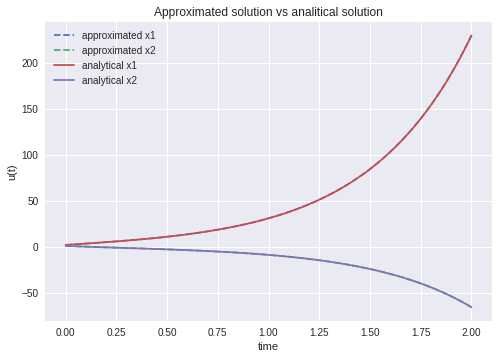

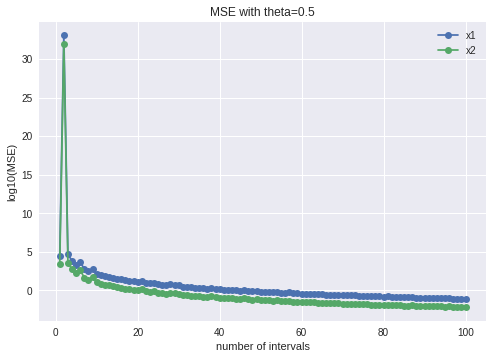

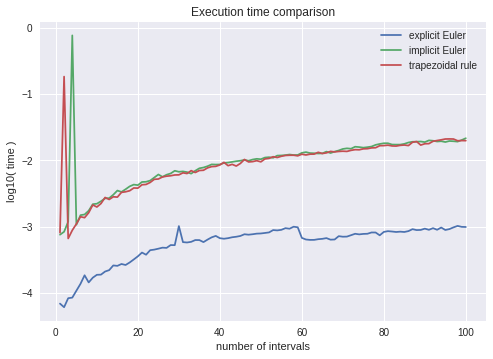

In [8]:
print('-----------------------------------------------------------------------')
print('------------------------ SYSTEM n° 1 ----------------------------------')
print('-----------------------------------------------------------------------')

def systemOdeFun(varVect,t):
  x1= varVect[0]
  x2= varVect[1]
  x3= varVect[2]
  fun1= 3*x1 + t
  fun2= x2 + 1
  fun3= x2 + x3
  
  vect= np.array( [[fun1],
                   [fun2],
                   [fun3]] )
  
  return vect

def systemFun(t):
  x1= (1/9)*np.e**(3*t) - (1/3)*t - (1/9)
  x2= np.e**t - 1
  x3= (t-1)*np.e**t + 1
  
  return x1, x2, x3

U0= [0, 0, 0]
T= 1.75
Nmax= 50
nTrials= 100 
analysisND(systemFun, systemOdeFun, U0, T, Nmax, nTrials)


print('-----------------------------------------------------------------------')
print('------------------------ SYSTEM n° 2 ----------------------------------')
print('-----------------------------------------------------------------------')

def systemOdeFun(varVect,t):
  x1= varVect[0]
  x2= varVect[1]
  
  fun1= 6*x1 + 5*x2 + np.e**(2*t)
  fun2= x1 + 2*x2 + 2*np.e**(2*t)
  
  vect= np.array( [[fun1],
                   [fun2]] )
  
  return vect

def systemFun(t):
  x1= (1/3)*np.e**t*(5*np.e**(6*t)+1) - (7/6)*np.e**t*(np.e**(6*t)-1) - 2*np.e**(2*t)
  x2= (1/3)*np.e**t*(np.e**(6*t)-1) - (7/30)*np.e**t*(np.e**(6*t)+5)  + (7*np.e**(2*t))/5
  
  return x1, x2


U0= [0, 0]
T= 2
Nmax= 100
nTrials= 100

analysisND(systemFun, systemOdeFun, U0, T, Nmax, nTrials)


print('-----------------------------------------------------------------------')
print('------------------------ SYSTEM n° 3 ----------------------------------')
print('-----------------------------------------------------------------------')

def systemOdeFun(varVect,t):
  x1= varVect[0]
  x2= varVect[1]
  f1= 4*x1 + 7*x2
  f2= -2*x1 -5*x2
  
  return np.array( [[f1],
                    [f2]])

def systemFun(t):
  x1= (2/5)*np.e**(-3*t)*(7*np.e**(5*t)-2) + (7/5)*np.e**(-3*t)*(np.e**(5*t)-1)
  x2= (-4/5)*np.e**(-3*t)*(np.e**(5*t)-1) - (1/5)*np.e**(-3*t)*(2*np.e**(5*t)-7)
  
  return x1, x2

U0= [2,1]
T= 2
Nmax= 100
nTrials= 100

analysisND(systemFun, systemOdeFun, U0, T, Nmax, nTrials)
  

##Discussion

As we can see from the Results section, the $\theta$-method is a very powerful method to solve ordinary differential equations and system of ordinary differential equations. But we can also observe that this method depends greatly on the number of subintervals dividing the time domain $[0,T]$: few intervals may lead to a very approximate solution, but many intervals increase the execution time as it is possible to observe on the time plots. In other words, depending on the application, if we prefer a faster but less accurate approximation we could use the explicit Euler, while if we prefer a slower but more accurate approximation we can use the trapezoidal method. 

Clearly, it is useless to adopt the implicit Euler method, because it requires the same execution time as the trapezoidal rule but it does not give a solution as acceptable as  the trapezoidal rule does. In fact, the trapezoidal rule obtains better approximation than both the explicit and the implicit Euler method: this is because in general when the implicit Euler method overstimates the solution, the explicit Euler method tends to understimate the solution, and vice versa. Thus, since the trapezoidal rule consists of the mean between the implicit and the explicit Euler method, the trapezoidal rule results to be more accurate than the others.

##References

[1] from *[Lab 3: Iterative methods](https://github.com/johanhoffman/DD2363-VT19/blob/bozzato/Lab-3/bozzato_lab3.ipynb)*

[2] from Wikipedia, *[Differential equation](https://en.wikipedia.org/wiki/Differential_equation)*

[3] from Lecture Notes, *Time stepping methods, chapter 14*, pg. 179

[4] from Lecture Notes, *The $\theta$-method, chapter 14*, pg. 184

[5] from Lecture Notes, *Newton's method, chapter 8*, pg. 116



#Extra assignment: the *preys and predators* model

##Introduction

The preys and predators model, also called *Volterra-Lotka equations*, is a set of two first-order nonlinear differential equations, frequently used to describe the evolution and the dynamics of biological system, where two species interact, one as prey and the other as predator [6].

###Definition
Before analysing the model, we need to make some assumption about the environment and evolution of the systems [8]:

1. preys find abundant food at all times;
2. the food supply of predators depends entirely on the size of the prey population;
3. the rate of change of population is proportional to its size;
4. the environment does not change in favour of one species, and genetic adaptation is irrilevant;
5. predators have limitless appetite.

Now, after making these assumptions, we can define the model, which is given by the following system of ordinary differential equations [7]:

>$
\begin{cases}
  \dfrac{dx}{dt}=\dot{x}= \alpha x - \beta xy \\
  \dfrac{dy}{dt}=\dot{y}= \delta xy - \gamma y
\end{cases}
$

where:
* $x$ is the number of preys and $\dot{x}$ is the rate of change of this population
* $y$ is the number of predators and $\dot{y}$ is the rate of change of this population
* $\alpha$ and $\gamma$ are positive parameters modelling birth and death rates for the two species
* $\beta$ and $\delta$ are the parameters for the predator-prey interactions.

###Solution
The system has two equilibrium point [7]: the first is the null solution, which is not interesting, and the second is 

>$
  \begin{pmatrix}
  x \\
  y
  \end{pmatrix} = \begin{pmatrix}
    \dfrac{\gamma}{\delta} \\
    \dfrac{\alpha}{\beta}
  \end{pmatrix}
$

The Jacobian matrix for this equilibrium point is

>$
\begin{pmatrix}
0 & -\dfrac{\beta\gamma}{\delta} \\
\dfrac{\delta\alpha}{\beta} & 0
\end{pmatrix}
$

with imaginary eigenvalues $\lambda= \pm j\sqrt{\alpha\gamma}$. This means that the solution is periodic around the equilibrium point $(\gamma/\delta,\alpha/\beta)$.

###The phase space
One typical way of showing the evolution of the two species is to use the so-called *phase space*, where all possible states of the system are represented, with each possible state corresponding to one unique point in the phase space [9]. This kind of graph is useful to see how the two species evolve with respect to the other.

##Method
In the ocean, the prey at the base of all pelagic marine food webs are autotrophic phytoplankton. The dominant predators for phytoplankton are herbivorous zooplankton, but many zooplankton are carnivorous and eat other zooplankton as well as phytonplankton [10]. 

We can modelize the phytoplankton-zooplankton interactions with the following prey-predator model:

>$
\begin{cases}
  \dfrac{dP}{dt} = bP - k_1PZ \qquad\qquad\qquad [\text{preys}]\\
  \dfrac{dZ}{dt}= k_2PZ - mZ - k_3Z^2 \qquad [\text{predators}]
\end{cases}
$

where:
* $b$ is the birth-death rate for phyplankton;
* $m$ is the mortality rate for zooplankton;
* $k_1$ is the rate of the grazing of phytoplankton by zooplankton;
* $ k_2$ is the rate at which the grazed phytoplankton are converted into zooplankton biomass;
* $k_3$ is the rate of carnivorous consumption of zooplankton by zooplankton.

###The equilibrium points
The equilibrium point is found by searching the points where the derivatives are equal to zero and from the equilibrium point analysis we can find three equilibrium points:

1. $(P,Z)= (0,0)$ which is not interesting as equilibrium point.
2. $(P,Z)=\left(0,-\dfrac{m}{k_3}\right)$ which is not acceptable because the number of individuals cannot be negative.
3. $(P,Z)=\left(\dfrac{k_1m+bk_3}{k_1k_2},\dfrac{b}{k_1}\right)$ which is the only interesting equilibrium point.

###The analysis
To analyze the problem, we will test the model with eight different set of values for the above parameters [10]: 

* System 1: 
>* $b= 1$ days$^{-1}$,
>* $m= 0.5$ days$^{-1}$, 
>* $k_1= 0.1$ days$^{-1}$, 
>* $k_2= 0.01$ days$^{-1}$
>* $k_3= 0$ days$^{-1}$
>* $P(0)=80$
>* $Z(0)=10$
>* with this set of parameters the equilibrium point is $(P,Z)=(50,10)$

* System 2:
>* $b= 1$ days$^{-1}$,
>* $m= 0.5$ days$^{-1}$, 
>* $k_1= 0.1$ days$^{-1}$, 
>* $k_2= 0.01$ days$^{-1}$
>* $k_3= 0$ days$^{-1}$
>* $P(0)=80$
>* $Z(0)=20$
>* with this set of parameters the equilibrium point is $(P,Z)=(50,10)$

* System 3:
>* $b= 1$ days$^{-1}$,
>* $m= 0.5$ days$^{-1}$, 
>* $k_1= 0.1$ days$^{-1}$, 
>* $k_2= 0.01$ days$^{-1}$
>* $k_3= 0$ days$^{-1}$
>* $P(0)=80$
>* $Z(0)=30$
>* with this set of parameters the equilibrium point is $(P,Z)=(50,10)$

* System 4:
>* $b= 1$ days$^{-1}$,
>* $m= 0.5$ days$^{-1}$, 
>* $k_1= 0.1$ days$^{-1}$, 
>* $k_2= 0.01$ days$^{-1}$
>* $k_3= 0$ days$^{-1}$
>* $P(0)=80$
>* $Z(0)=40$
>* with this set of parameters the equilibrium point is $(P,Z)=(50,10)$

* System 5:
>* $b= 1$ days$^{-1}$,
>* $m= 0.5$ days$^{-1}$, 
>* $k_1= 0.1$ days$^{-1}$, 
>* $k_2= 0.01$ days$^{-1}$
>* $k_3= 0.01$ days$^{-1}$
>* $P(0)=80$
>* $Z(0)=30$
>* with this set of parameters the equilibrium point is $(P,Z)=(60,10)$

* System 6:
>* $b= 1$ days$^{-1}$,
>* $m= 0.5$ days$^{-1}$, 
>* $k_1= 0.1$ days$^{-1}$, 
>* $k_2= 0.01$ days$^{-1}$
>* $k_3= 0.01$ days$^{-1}$
>* $P(0)=80$
>* $Z(0)=40$
>* with this set of parameters the equilibrium point is $(P,Z)=(60,10)$

* System 7:
>* $b= 1$ days$^{-1}$,
>* $m= 0.5$ days$^{-1}$, 
>* $k_1= 0.1$ days$^{-1}$, 
>* $k_2= 0.01$ days$^{-1}$
>* $k_3= 0.05$ days$^{-1}$
>* $P(0)=80$
>* $Z(0)=30$
>* with this set of parameters the equilibrium point is $(P,Z)=(100,10)$

* System 8:
>* $b= 1$ days$^{-1}$,
>* $m= 0.5$ days$^{-1}$, 
>* $k_1= 0.1$ days$^{-1}$, 
>* $k_2= 0.01$ days$^{-1}$
>* $k_3= 0.05$ days$^{-1}$
>* $P(0)=80$
>* $Z(0)=40$
>* with this set of parameters the equilibrium point is $(P,Z)=(100,10)$

In [0]:
################################################################################
#####                            SYSTEMS 1-2-3-4                           #####
################################################################################



def system1(varVect,t):
  b= 1
  m= 0.5
  k1= 0.1
  k2= 0.01
  k3= 0
  
  P= varVect[0]
  Z= varVect[1]
  
  f1= b*P - k1*P*Z
  f2= k2*P*Z - m*Z - k3*Z**2
  
  sys= np.array( [[f1],
                  [f2]] )
  
  return sys

################################################################################
#####                              SYSTEMS 5-6                             #####
################################################################################
def system5(varVect,t):
  b= 1
  m= 0.5
  k1= 0.1
  k2= 0.01
  k3= 0.01
  
  P= varVect[0]
  Z= varVect[1]
  
  f1= b*P - k1*P*Z
  f2= k2*P*Z - m*Z - k3*Z**2
  
  sys= np.array( [[f1],
                  [f2]] )
  
  return sys

################################################################################
#####                              SYSTEMS 7-8                             #####
################################################################################
def system7(varVect,t):
  b= 1
  m= 0.5
  k1= 0.1
  k2= 0.01
  k3= 0.05
  
  P= varVect[0]
  Z= varVect[1]
  
  f1= b*P - k1*P*Z
  f2= k2*P*Z - m*Z - k3*Z**2
  
  sys= np.array( [[f1],
                  [f2]] )
  
  return sys

##Results




------------------------------------------------------
-------------- P(0)= 80 and Z(0)= 10-----------------
------------------------------------------------------


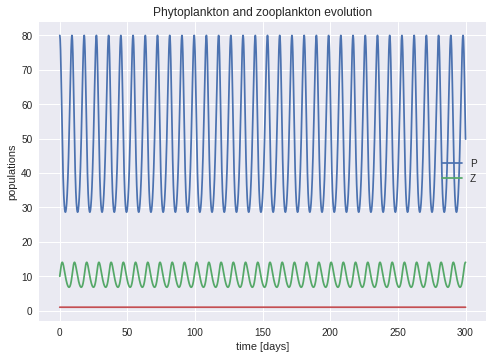

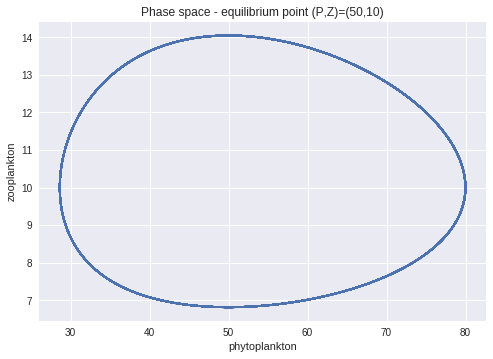

------------------------------------------------------
-------------- P(0)= 80 and Z(0)= 20-----------------
------------------------------------------------------


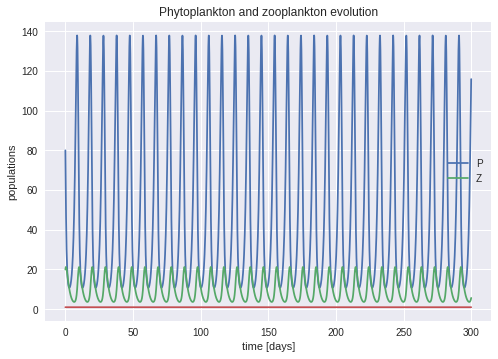

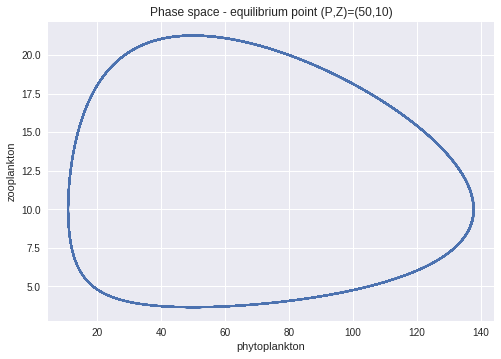

------------------------------------------------------
-------------- P(0)= 80 and Z(0)= 30-----------------
------------------------------------------------------


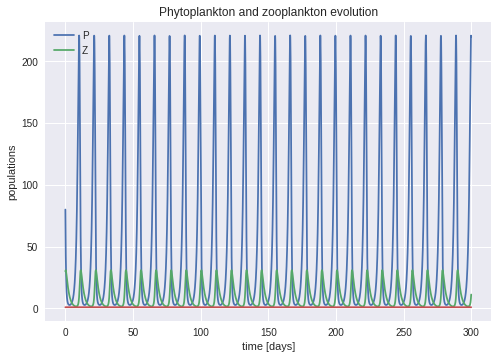

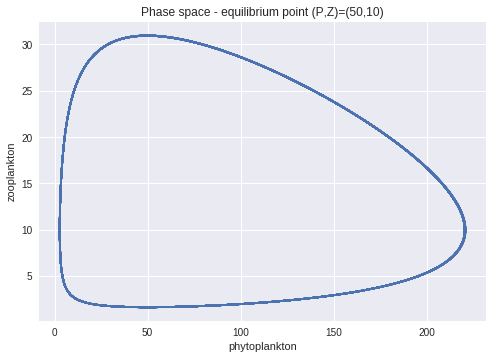

------------------------------------------------------
-------------- P(0)= 80 and Z(0)= 40-----------------
------------------------------------------------------


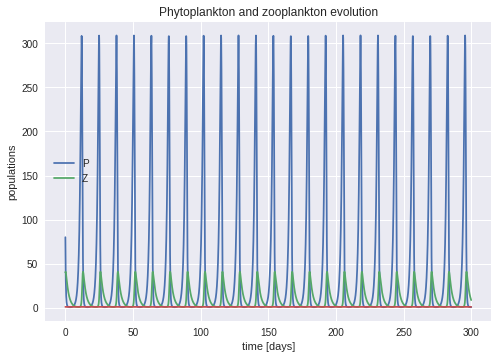

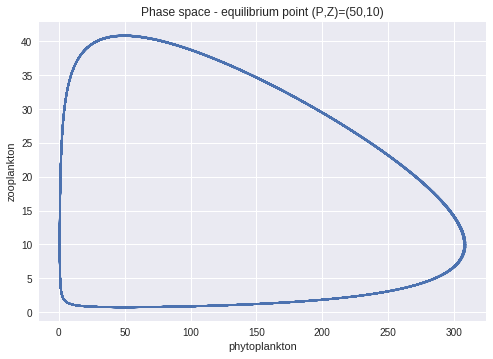

In [10]:
################################################################################
#####                            SYSTEMS 1-2-3-4                           #####
################################################################################

P0= 80
Z0= [10, 20, 30, 40]
T= 300
N= 3000
theta= 0.5

for z in Z0:
  print('------------------------------------------------------')
  print('-------------- P(0)= {} and Z(0)= {}-----------------'.format(P0,z))
  print('------------------------------------------------------')
  t, X= systemOdeSolver(T, system1, theta, [P0, z], N)
  
  plt.figure()
  plt.plot(t,X[0,:])
  plt.plot(t,X[1,:])
  plt.plot(t, np.ones_like(t))
  plt.xlabel('time [days]')
  plt.ylabel('populations')
  plt.title('Phytoplankton and zooplankton evolution')
  plt.legend(['P', 'Z'])
  plt.show()

  plt.figure()
  plt.plot(X[0,:],X[1,:])
  plt.xlabel('phytoplankton')
  plt.ylabel('zooplankton')
  plt.title('Phase space - equilibrium point (P,Z)=(50,10)')
  
  plt.show()

------------------------------------------------------
-------------- P(0)= 80 and Z(0)= 30-----------------
------------------------------------------------------


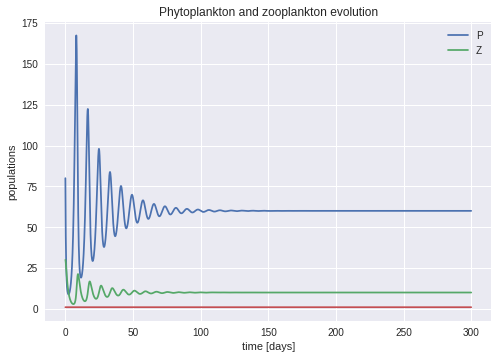

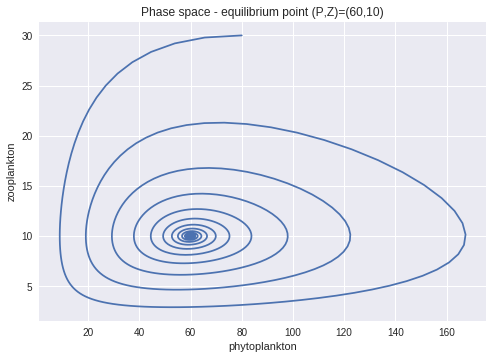

------------------------------------------------------
-------------- P(0)= 80 and Z(0)= 40-----------------
------------------------------------------------------


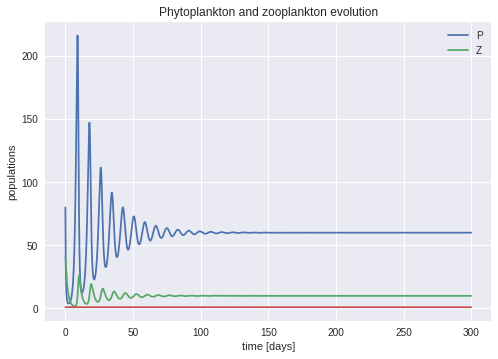

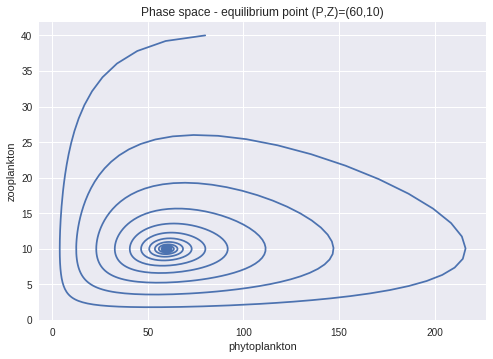

In [11]:
################################################################################
#####                              SYSTEMS 5-6                             #####
################################################################################
P0= 80
Z0= [30, 40]
T= 300
N= 3000
theta= 0.5

for z in Z0:
  print('------------------------------------------------------')
  print('-------------- P(0)= {} and Z(0)= {}-----------------'.format(P0,z))
  print('------------------------------------------------------')
  t, X= systemOdeSolver(T, system5, theta, [P0, z], N)
  
  plt.figure()
  plt.plot(t,X[0,:])
  plt.plot(t,X[1,:])
  plt.plot(t, np.ones_like(t))
  plt.xlabel('time [days]')
  plt.ylabel('populations')
  plt.title('Phytoplankton and zooplankton evolution')
  plt.legend(['P', 'Z'])
  plt.show()

  plt.figure()
  plt.plot(X[0,:],X[1,:])
  plt.xlabel('phytoplankton')
  plt.ylabel('zooplankton')
  plt.title('Phase space - equilibrium point (P,Z)=(60,10)')
  
  plt.show()

------------------------------------------------------
-------------- P(0)= 80 and Z(0)= 30-----------------
------------------------------------------------------


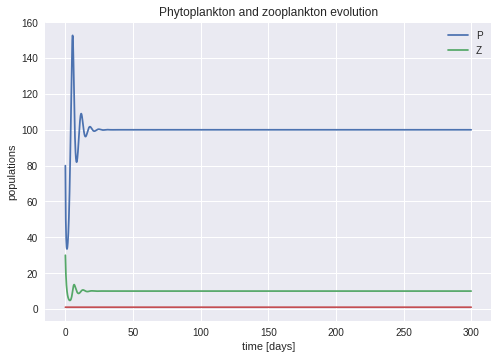

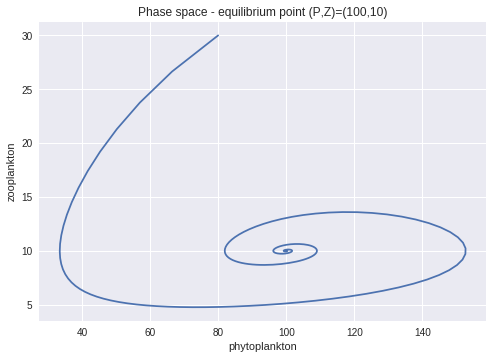

------------------------------------------------------
-------------- P(0)= 80 and Z(0)= 40-----------------
------------------------------------------------------


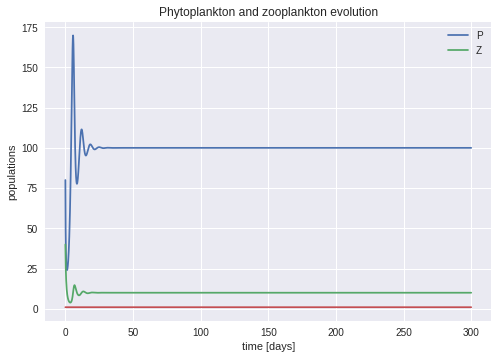

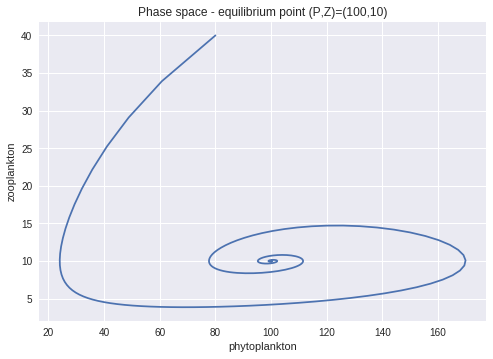

In [12]:
################################################################################
#####                              SYSTEMS 7-8                             #####
################################################################################
P0= 80
Z0= [30, 40]
T= 300
N= 3000
theta= 0.5

for z in Z0:
  print('------------------------------------------------------')
  print('-------------- P(0)= {} and Z(0)= {}-----------------'.format(P0,z))
  print('------------------------------------------------------')
  t, X= systemOdeSolver(T, system7, theta, [P0, z], N)
  
  plt.figure()
  plt.plot(t,X[0,:])
  plt.plot(t,X[1,:])
  plt.plot(t, np.ones_like(t))
  plt.xlabel('time [days]')
  plt.ylabel('populations')
  plt.title('Phytoplankton and zooplankton evolution')
  plt.legend(['P', 'Z'])
  plt.show()

  plt.figure()
  plt.plot(X[0,:],X[1,:])
  plt.xlabel('phytoplankton')
  plt.ylabel('zooplankton')
  plt.title('Phase space - equilibrium point (P,Z)=(100,10)')
  
  plt.show()

##Discussion
CHECK [8] FOR THE CONCLUSIONS.

##References

[6] from Wikipedia, *[Preys and predators model](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations)*

[7] from Lecture Notes, *Predator-prey systems, chapter 15*, pg. 197

[8] *[Predator-prey dynamics](http://www.tiem.utk.edu/~gross/bioed/bealsmodules/predator-prey.html)*

[9] from Wikipedia, *[Phase space](https://en.wikipedia.org/wiki/Phase_space)*

[10] *[A prey and predators model for phytoplankton-zooplankton interactions](https://people.ucsc.edu/~ammoore/migrated/ocea286/EXERCISES/exercise1.pdf)*